In [2]:
%%shell
wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
conda install -q -y --prefix /usr/local python=3.6 gdal

--2023-05-01 14:11:36--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   247MB/s    in 0.2s    

2023-05-01 14:11:36 (247 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6

In [1]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import copy

from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
def show_image(image, title_img='', path_to_save=None):
    f = plt.figure(figsize=(5, 5))  
    
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if title_img:
        plt.title(title_img)

    if path_to_save is not None:
        plt.imsave(f"{path_to_save}.png", image)  
    plt.show()

In [5]:
def get_image_RGB(filename):
    image = gdal.Open(filename)
    # As, there are 3 bands, we will store in 3 different variables 
    band_1 = image.GetRasterBand(1) # red channel  
    band_2 = image.GetRasterBand(2) # green channel  
    band_3 = image.GetRasterBand(3) # blue channel   
    # band_4 = image.GetRasterBand(4) # alpha channel
    b1 = band_1.ReadAsArray()  
    b2 = band_2.ReadAsArray()  
    b3 = band_3.ReadAsArray()
    # b4 = band_4.ReadAsArray()
    # Normalize input image to range [0, 255]
    normalized_b1 = cv2.normalize(b1, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    normalized_b2 = cv2.normalize(b2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  
    normalized_b3 = cv2.normalize(b3, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # normalized_b4 = cv2.normalize(b3, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return np.dstack((normalized_b1, normalized_b2, normalized_b3))


In [6]:
def morph_operations(image_arr):
    # denoise the image with a Gaussian filter
    blurred_image = cv2.GaussianBlur(image_arr, (5, 5), 0)

    # Remove noise and fill holes in the binary image using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    return cv2.morphologyEx(image_arr, cv2.MORPH_OPEN, kernel)


def otsu_method(image):
    # For debuging use cv2_imshow
    # Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
    # Use a bimodal image as an input.
    # Optimal threshold value is determined automatically.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # denoise the image with a Gaussian filter
    blurred_image = cv2.GaussianBlur(gray,(5,5),0)

    otsu_threshold, image_result = cv2.threshold(
        blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    )

    # Remove noise and fill holes in the binary image using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    closed = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel)

    return closed


def draw_contours(thresh, image, clr=(0, 255, 0)):

    # Find the contours in the input image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    image_copy = copy.deepcopy(image)
    # Draw the contours on an image
    contour_img = cv2.drawContours(image_copy, contours, -1, clr, 5)

    return contour_img

In [7]:
model = load_model('/content/drive/MyDrive/models_deforestation/unet-attention-3d.hdf5')

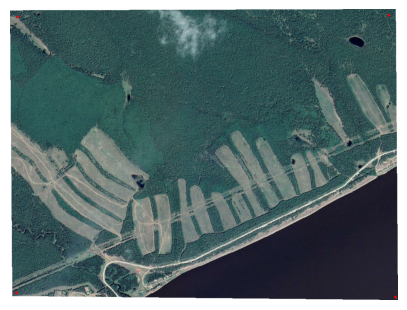

In [8]:
FILENAME = '/content/drive/MyDrive/deforestation/deforestation_2.tif'
image = get_image_RGB(FILENAME)

show_image(image)

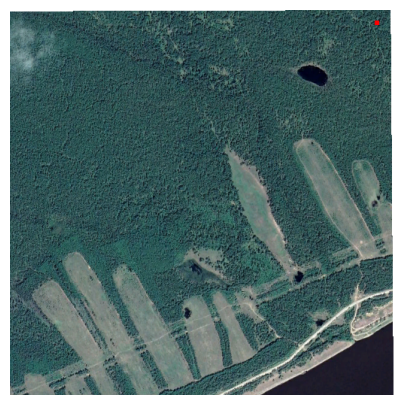

In [9]:
image = image[0:512, 512:1024, :]
show_image(image)

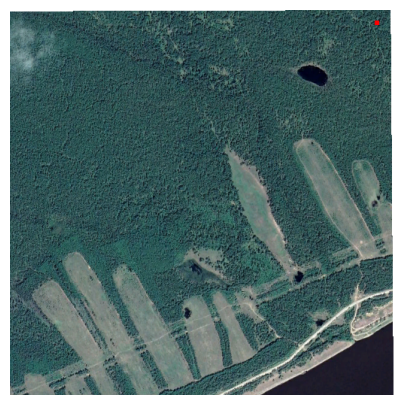

(512, 512, 3)

In [10]:
resized_image = cv2.resize(image, (512, 512))
show_image(resized_image)
image_norm = resized_image / 255
image_norm.shape



In [11]:
prediction = model.predict(image_norm.reshape(1, 512, 512, 3))

1/1 [==============================] - 1s 1s/step


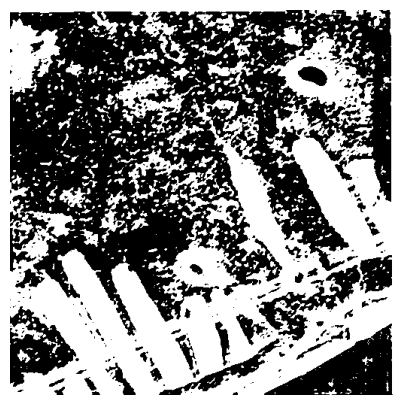

In [12]:
mask = prediction[0] > 0.5
show_image(mask)

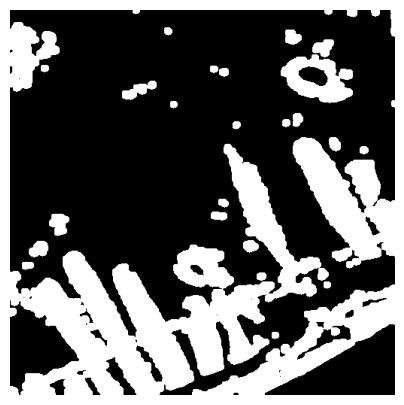

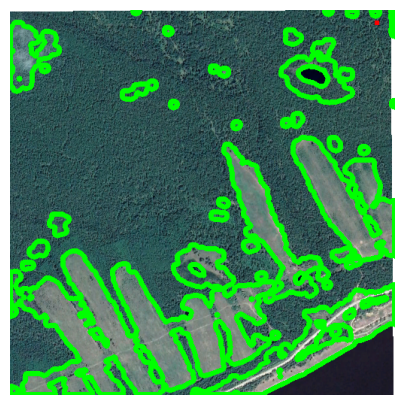

In [13]:
mask = (np.round(prediction[0])).astype(np.uint8)
denoised_img = morph_operations(mask)
show_image(denoised_img)
contour_img = draw_contours(denoised_img, resized_image)

show_image(contour_img)

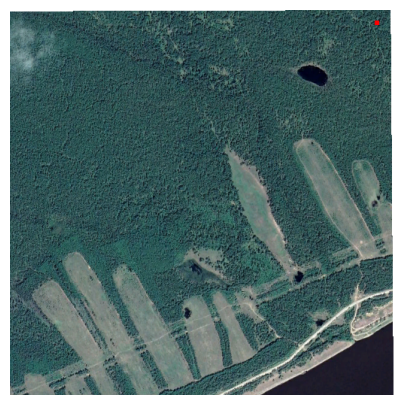

In [14]:
show_image(resized_image)